In [3]:
from IPython.display import Image

# Text Classification

La clasificaci√≥n de texto es una de las tareas m√°s comunes en NLP; puede usarse para una amplia gama de aplicaciones, como etiquetar comentarios de clientes en categor√≠as o enrutar tickets de soporte seg√∫n su idioma. Es probable que el filtro de spam de tu programa de correo electr√≥nico est√© utilizando clasificaci√≥n de texto para proteger tu bandeja de entrada de una avalancha de basura no deseada!

Otro tipo com√∫n de clasificaci√≥n de texto es el sentiment analysis, que  tiene como objetivo identificar la polaridad de un texto dado. Por ejemplo, una empresa como Tesla podr√≠a analizar publicaciones de Twitter como la de la Figura 2-1 para determinar si a la gente le gustan o no sus nuevos techos de autom√≥viles.

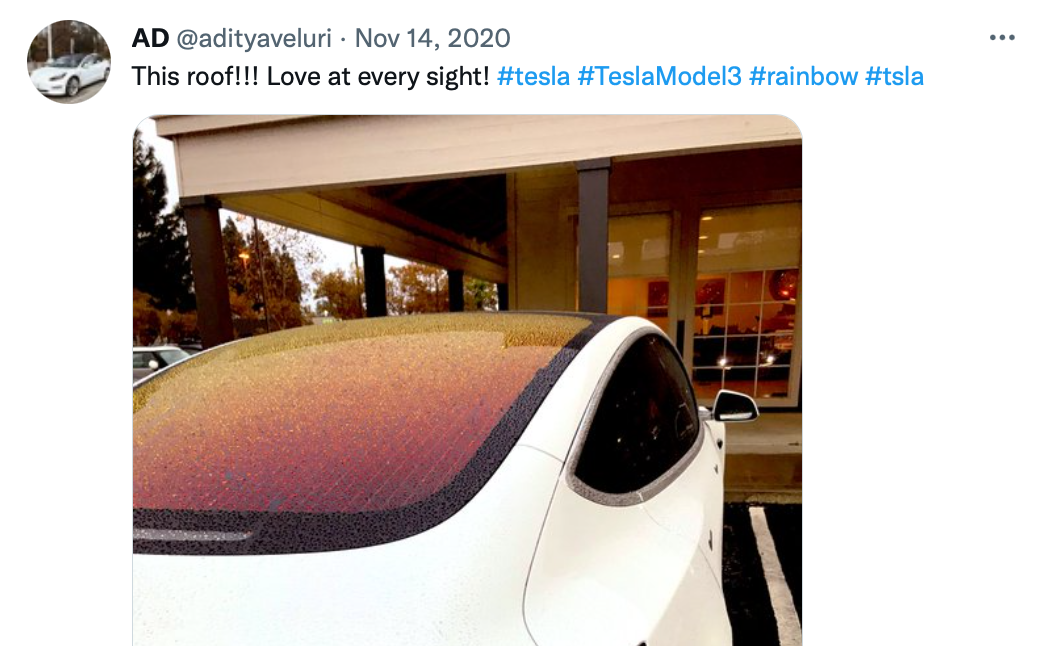

In [7]:
Image("images/chapter02_tweet.png", width=500)

Ahora imagina que eres un cient√≠fico de datos que necesita construir un sistema que pueda identificar autom√°ticamente estados emocionales como "anger" o "joy" que las personas expresan sobre el producto de tu empresa en Twitter. En este cap√≠tulo, abordaremos esta tarea utilizando una variante de BERT llamada DistilBERT. La principal ventaja de este modelo es que logra un rendimiento comparable a BERT, siendo significativamente m√°s peque√±o y eficiente. Esto nos permite entrenar un clasificador en unos minutos, y si quieres entrenar un modelo BERT m√°s grande, simplemente puedes cambiar el checkpoint del modelo preentrenado. Un checkpoint corresponde al conjunto de pesos que se cargan en una arquitectura transformer dada.

Este tambi√©n ser√° nuestro primer encuentro con tres de las bibliotecas principales del ecosistema de Hugging Face:
ü§ó Datasets,
ü§ó Tokenizers, y
ü§ó Transformers. 

Como se muestra en la Figura 2-2, estas bibliotecas nos permitir√°n pasar r√°pidamente de texto sin procesar a un modelo fine-tuned que se puede usar para inferencia en nuevos tweets. As√≠ que, en el esp√≠ritu de Optimus Prime, ¬°sumerj√°monos, "transform, and roll out!"

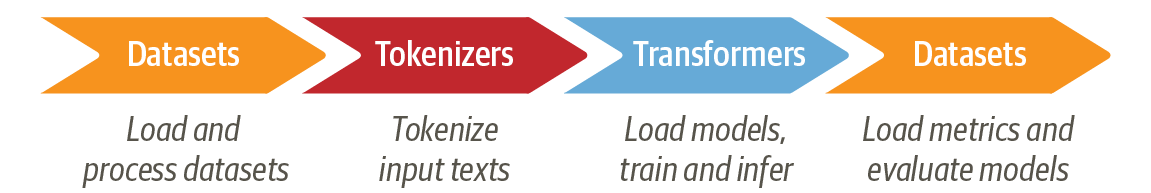

In [5]:
Image("images/chapter02_hf-libraries.png", width=700)

## El Dataset

Para construir nuestro detector de emociones, usaremos un excelente dataset de un art√≠culo que explor√≥ c√≥mo se representan las emociones en los mensajes de Twitter en ingl√©s. A diferencia de la mayor√≠a de los datasets de sentiment analysis que involucran solo polaridades "positive" y "negative", este dataset contiene seis emociones b√°sicas: anger, disgust, fear, joy, sadness y surprise. Dado un tweet, nuestra tarea ser√° entrenar un modelo que pueda clasificarlo en una de estas emociones.

### Una Primera Mirada a Hugging Face Datasets

Usaremos ü§ó Datasets para descargar los datos del [Hugging Face Hub](https://huggingface.co/datasets). Podemos usar la funci√≥n `list_datasets()` para ver qu√© datasets est√°n disponibles en el Hub:

In [ ]:
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 1753 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


Vemos que a cada dataset se le asigna un nombre, as√≠ que carguemos el dataset `emotion` con la funci√≥n `load_dataset()`:

In [ ]:
# hide_output
from datasets import load_dataset

emotions = load_dataset("emotion")

Si miramos dentro de nuestro objeto `emotions`:

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

vemos que es similar a un diccionario de Python, con cada clave correspondiente a un split diferente. Y podemos usar la sintaxis habitual de diccionario para acceder a un split individual:

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

que devuelve una instancia de la clase `Dataset`. El objeto `Dataset` es una de las estructuras de datos centrales en ü§ó Datasets, y exploraremos muchas de sus caracter√≠sticas a lo largo de este libro. Para empezar, se comporta como un array o lista ordinaria de Python, por lo que podemos consultar su longitud:

In [ ]:
len(train_ds)

16000

o acceder a un solo ejemplo por su √≠ndice:

In [ ]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

Aqu√≠ vemos que una sola fila est√° representada como un diccionario, donde las claves corresponden a los nombres de las columnas:

In [ ]:
train_ds.column_names

['text', 'label']

y los valores son el tweet y la emoci√≥n. Esto refleja el hecho de que ü§ó Datasets se basa en [_Apache Arrow_](https://arrow.apache.org/), que define un formato columnar tipado que es m√°s eficiente en memoria que el Python nativo. Podemos ver qu√© tipos de datos se est√°n utilizando internamente accediendo al atributo `features` de un objeto `Dataset`:

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6,
names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None,
id=None)}


En este caso, el tipo de datos de la columna `text` es `string`, mientras que la columna `label` es un objeto `ClassLabel` especial que contiene informaci√≥n sobre los nombres de las clases y su mapeo a enteros. Tambi√©n podemos acceder a varias filas con un slice:

In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


Ten en cuenta que en este caso, los valores del diccionario son ahora listas en lugar de elementos individuales. Tambi√©n podemos obtener la columna completa por nombre:

In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned
hopeful just from being around someone who cares and is awake', 'im grabbing a
minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the
fireplace i will know that it is still on the property', 'i am feeling grouchy']


Ahora que hemos visto c√≥mo cargar e inspeccionar datos con ü§ó Datasets, hagamos algunas comprobaciones de cordura sobre el contenido de nuestros tweets.

> #### ¬øQu√© pasa si mi Dataset no est√° en el Hub?

Usaremos el Hugging Face Hub para descargar datasets para la mayor√≠a de los ejemplos. Pero en muchos casos, te encontrar√°s trabajando con datos que est√°n almacenados en tu laptop o en un servidor remoto en tu organizaci√≥n. ü§ó Datasets proporciona varios scripts de carga para manejar datasets locales y remotos. En <<dataset-loading>> se muestran ejemplos para los formatos de datos m√°s comunes.

C√≥mo cargar datasets en varios formatos

| Formato de datos | Script de carga | Ejemplo |
| --- | --- | --- |
| CSV | `csv` | `load_dataset("csv", data_files="my_file.csv")` |
| Text | `text` | `load_dataset("text", data_files="my_file.txt")` |
| JSON | `json` | `load_dataset("json", data_files="my_file.jsonl")` |

Como puedes ver, para cada formato de datos, solo necesitamos pasar el script de carga relevante a la funci√≥n `load_dataset()`, junto con un argumento `data_files` que especifica la ruta o URL a uno o m√°s archivos. Por ejemplo, los archivos fuente para el dataset `emotion` est√°n realmente alojados en Dropbox, por lo que una forma alternativa de cargar el dataset es primero descargar uno de los splits:

In [ ]:
# The original URL used in the book is no longer available, so we use a different one
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

Si te preguntas por qu√© hay un car√°cter `!` en el comando de shell anterior, es porque estamos ejecutando los comandos en un notebook Jupyter. Simplemente elimina el prefijo si quieres descargar y descomprimir el dataset dentro de una terminal. Ahora, si echamos un vistazo a la primera fila del archivo _train.txt_:

In [ ]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


podemos ver que no hay encabezados de columna y cada tweet y emoci√≥n est√°n separados por un punto y coma. Sin embargo, esto es bastante similar a un archivo CSV, por lo que podemos cargar el dataset localmente usando el script `csv` y apuntando el argumento `data_files` al archivo _train.txt_:

In [ ]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", 
                              names=["text", "label"])

Aqu√≠ tambi√©n hemos especificado el tipo de delimitador y los nombres de las columnas. Un enfoque a√∫n m√°s simple es simplemente apuntar el argumento `data_files` a la URL misma:

In [ ]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"])

que descargar√° y almacenar√° en cach√© autom√°ticamente el dataset para ti. Como puedes ver, la funci√≥n `load_dataset()` es muy vers√°til. Recomendamos consultar la [documentation](https://huggingface.co/docs/datasets/loading.html) de ü§ó Datasets para obtener una visi√≥n general completa.

### De Datasets a DataFrames

Aunque ü§ó Datasets proporciona mucha funcionalidad de bajo nivel para cortar y dividir nuestros datos, a menudo es conveniente convertir un objeto `Dataset` en un `DataFrame` de Pandas para poder acceder a APIs de alto nivel para la visualizaci√≥n de datos. Para habilitar la conversi√≥n, ü§ó Datasets proporciona un m√©todo `set_format()` que nos permite cambiar el _formato de salida_ del `Dataset`. Ten en cuenta que esto no cambia el _formato de datos_ subyacente (que es una tabla Arrow), y puedes cambiar a otro formato m√°s tarde si es necesario:

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3

Como puedes ver, los encabezados de las columnas se han conservado y las primeras filas coinciden con nuestras vistas anteriores de los datos. Sin embargo, las etiquetas est√°n representadas como enteros, as√≠ que usemos el m√©todo `int2str()` de la caracter√≠stica `label` para crear una nueva columna en nuestro `DataFrame` con los nombres de etiquetas correspondientes:

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

text  label label_name
0                            i didnt feel humiliated      0    sadness
1  i can go from feeling so hopeless to so damned...      0    sadness
2   im grabbing a minute to post i feel greedy wrong      3      anger
3  i am ever feeling nostalgic about the fireplac...      2       love
4                               i am feeling grouchy      3      anger

Antes de sumergirnos en la construcci√≥n de un clasificador, echemos un vistazo m√°s cercano al conjunto de datos. Como nota Andrej Karpathy en su famoso post de blog ["Una receta para entrenar redes neuronales"](https://karpathy.github.io/2019/04/25/recipe), convertirse en "uno con los datos" es un paso esencial para entrenar modelos excelentes.

### Observando la Distribuci√≥n de Clases

Siempre que est√©s trabajando en problemas de clasificaci√≥n de texto, es una buena idea examinar la distribuci√≥n de ejemplos en las clases. Un conjunto de datos con una distribuci√≥n de clases sesgada podr√≠a requerir un tratamiento diferente en t√©rminos de la p√©rdida de entrenamiento y las m√©tricas de evaluaci√≥n que uno equilibrado. 

Con Pandas y Matplotlib, podemos visualizar r√°pidamente la distribuci√≥n de clases de la siguiente manera:

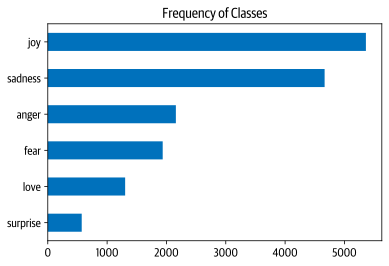

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

En este caso, podemos ver que el conjunto de datos est√° muy desequilibrado; las clases `joy` y `sadness` aparecen con frecuencia, mientras que `love` y `surprise` son aproximadamente 5-10 veces m√°s raras. Hay varias formas de lidiar con datos desequilibrados, incluyendo:

* Sobremuestrear aleatoriamente la clase minoritaria.
* Submuestrear aleatoriamente la clase mayoritaria.
* Recopilar m√°s datos etiquetados de las clases subrepresentadas.

Para mantener las cosas simples en este cap√≠tulo, trabajaremos con las frecuencias de clases crudas y desequilibradas. Si deseas aprender m√°s sobre estas t√©cnicas de muestreo, recomendamos echar un vistazo a la [biblioteca Imbalanced-learn](https://imbalanced-learn.org/stable/). ¬°Aseg√∫rate de no aplicar m√©todos de muestreo _antes_ de crear tus divisiones de entrenamiento/prueba, o tendr√°s mucha fuga entre ellas!

Ahora que hemos visto las clases, echemos un vistazo a los tweets mismos.

### Que tan largos son nuestros Tweets?

Los modelos Transformer tienen una longitud m√°xima de secuencia de entrada que se refiere como el _tama√±o m√°ximo de contexto_. Para aplicaciones que usan DistilBERT, el tama√±o m√°ximo de contexto es de 512 tokens, lo que equivale a unos pocos p√°rrafos de texto. Como veremos en la pr√≥xima secci√≥n, un token es una pieza at√≥mica de texto; por ahora, trataremos un token como una sola palabra. Podemos obtener una estimaci√≥n aproximada de las longitudes de los tweets por emoci√≥n examinando la distribuci√≥n de palabras por tweet:

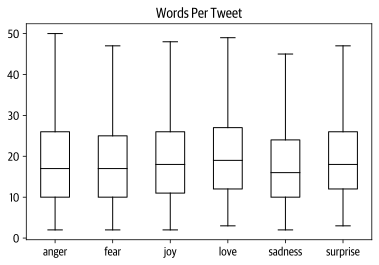

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Desde el gr√°fico vemos que para cada emoci√≥n, la mayor√≠a de los tweets tienen alrededor de 15 palabras y los tweets m√°s largos est√°n muy por debajo del tama√±o m√°ximo de contexto de DistilBERT. Los textos que son m√°s largos que el tama√±o de contexto de un modelo necesitan ser truncados, lo que puede llevar a una p√©rdida de rendimiento si el texto truncado contiene informaci√≥n crucial; en este caso, parece que eso no ser√° un problema. 

¬°Ahora vamos a averiguar c√≥mo podemos convertir estos textos crudos en un formato adecuado para los Transformers de hugging face! Mientras estamos en ello, tambi√©n vamos a restablecer el formato de salida de nuestro conjunto de datos ya que ya no necesitamos el formato `DataFrame`: 

In [ ]:
emotions.reset_format()

## De Texto a Tokens

Los modelos Transformer como DistilBERT no pueden recibir cadenas de texto sin procesar como entrada; en su lugar, asumen que el texto ha sido _tokenizado_ y _codificado_ como vectores num√©ricos. La tokenizaci√≥n es el paso de dividir una cadena en las unidades at√≥micas utilizadas en el modelo. Existen varias estrategias de tokenizaci√≥n que se pueden adoptar, y la divisi√≥n √≥ptima de palabras en subunidades generalmente se aprende del corpus. Antes de observar el tokenizer utilizado para DistilBERT, consideremos dos casos extremos: la tokenizaci√≥n a nivel de _car√°cter_ y a nivel de _palabra_.

### Tokenizaci√≥n a Nivel de Car√°cter

El esquema de tokenizaci√≥n m√°s simple es alimentar cada car√°cter individualmente al modelo. En Python, los objetos `str` son realmente arrays bajo el cap√≥, lo que nos permite implementar r√°pidamente la tokenizaci√≥n a nivel de car√°cter con solo una l√≠nea de c√≥digo:

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


Este es un buen comienzo, pero a√∫n no hemos terminado. Nuestro modelo espera que cada car√°cter se convierta en un entero, un proceso a veces llamado _numericalization_. Una forma simple de hacer esto es codificar cada token √∫nico (que en este caso son caracteres) con un entero √∫nico:

In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


Esto nos da un mapeo de cada car√°cter en nuestro vocabulario a un entero √∫nico. Ahora podemos usar `token2idx` para transformar el texto tokenizado en una lista de enteros:

In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Cada token ahora ha sido mapeado a un identificador num√©rico √∫nico (de ah√≠ el nombre `input_ids`). El √∫ltimo paso es convertir `input_ids` en un tensor 2D de vectores one-hot. Los vectores one-hot se utilizan frecuentemente en machine learning para codificar datos categ√≥ricos, que pueden ser ordinales o nominales. Por ejemplo, supongamos que queremos codificar los nombres de los personajes en la serie de TV _Transformers_. Una forma de hacer esto ser√≠a mapear cada nombre a un ID √∫nico, de la siguiente manera:


In [ ]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

Name  Label ID
0      Bumblebee         0
1  Optimus Prime         1
2       Megatron         2

El problema con este enfoque es que crea un orden ficticio entre los nombres, y las redes neuronales son _realmente_ buenas para aprender este tipo de relaciones. As√≠ que en su lugar, podemos crear una nueva columna para cada categor√≠a y asignar un 1 donde la categor√≠a sea verdadera, y un 0 en caso contrario. En Pandas, esto se puede implementar con la funci√≥n `get_dummies()` de la siguiente manera:

In [ ]:
pd.get_dummies(categorical_df["Name"])

Bumblebee  Megatron  Optimus Prime
0          1         0              0
1          0         0              1
2          0         1              0

Las filas de este `DataFrame` son los vectores one-hot, que tienen una sola entrada "caliente" con un 1 y 0s en todas partes. Ahora, mirando nuestros `input_ids`, tenemos un problema similar: los elementos crean una escala ordinal. Esto significa que sumar o restar dos IDs es una operaci√≥n sin sentido, ya que el resultado es un nuevo ID que representa otro token aleatorio.


Por otro lado, el resultado de sumar dos codificaciones one-hot puede interpretarse f√°cilmente: las dos entradas que est√°n "calientes" indican que los tokens correspondientes co-ocurren. Podemos crear las codificaciones one-hot en PyTorch convirtiendo `input_ids` en un tensor y aplicando la funci√≥n `one_hot()` de la siguiente manera:

In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

Para cada uno de los 38 tokens de entrada, ahora tenemos un vector one-hot con 20 dimensiones, ya que nuestro vocabulario consta de 20 caracteres √∫nicos.

> Advertencia: Es importante siempre establecer `num_classes` en la funci√≥n `one_hot()` porque de lo contrario los vectores one-hot pueden terminar siendo m√°s cortos que la longitud del vocabulario (y necesitar ser rellenados con ceros manualmente).

Al examinar el primer vector, podemos verificar que aparece un 1 en la ubicaci√≥n indicada por `input_ids[0]`:

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


En nuestro simple ejemplo podemos ver que la tokenizaci√≥n a nivel de car√°cter ignora cualquier estructura en el texto y trata toda la cadena como un flujo de caracteres. Aunque esto ayuda a lidiar con errores ortogr√°ficos y palabras raras, el principal inconveniente es que las estructuras ling√º√≠sticas como las palabras necesitan ser _aprendidas_ a partir de los datos. Esto requiere un c√≥mputo, memoria y datos significativos. Por esta raz√≥n, la tokenizaci√≥n a nivel de car√°cter rara vez se usa en la pr√°ctica. En su lugar, se preserva alguna estructura del texto durante el paso de tokenizaci√≥n. La _tokenizaci√≥n a nivel de palabra_ es un enfoque sencillo para lograr esto, as√≠ que veamos c√≥mo funciona.

### Word Tokenization

En lugar de dividir el texto en caracteres, podemos dividirlo en palabras y mapear cada palabra a un entero. Usar palabras desde el principio permite al modelo omitir el paso de aprender palabras a partir de caracteres, y as√≠ reducir la complejidad del proceso de entrenamiento.

Una clase simple de tokenizers de palabras usa espacios en blanco para tokenizar el texto. Podemos hacer esto aplicando directamente la funci√≥n `split()` de Python en el texto sin procesar (tal como hicimos para medir las longitudes de los tweets):

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


A partir de aqu√≠ podemos seguir los mismos pasos que tomamos para el tokenizer de caracteres para mapear cada palabra a un ID. Sin embargo, ya podemos ver un problema potencial con este esquema de tokenizaci√≥n: la puntuaci√≥n no se tiene en cuenta, por lo que `NLP.` se trata como un solo token. Dado que las palabras pueden incluir declinaciones, conjugaciones o errores ortogr√°ficos, el tama√±o del vocabulario puede crecer f√°cilmente hasta los millones!

> nota: Algunos tokenizers de palabras tienen reglas adicionales para la puntuaci√≥n. Tambi√©n se puede aplicar stemming o lematizaci√≥n, que normaliza las palabras a su ra√≠z (por ejemplo, "great", "greater" y "greatest" se convierten en "great"), a costa de perder algo de informaci√≥n en el texto.

Tener un vocabulario grande es un problema porque requiere que las redes neuronales tengan una cantidad enorme de par√°metros. Para ilustrar esto, supongamos que tenemos 1 mill√≥n de palabras √∫nicas y queremos comprimir los vectores de entrada de 1 mill√≥n de dimensiones a vectores de 1 mil dimensiones en la primera capa de nuestra red neuronal. Este es un paso est√°ndar en la mayor√≠a de las arquitecturas de NLP, y la matriz de pesos resultante de esta primera capa contendr√≠a 1 mill√≥n $\times$ 1 mil = 1 mil millones de pesos. Esto ya es comparable al modelo GPT-2 m√°s grande, que tiene alrededor de 1.5 mil millones de par√°metros en total!

Naturalmente, queremos evitar ser tan derrochadores con los par√°metros de nuestro modelo, ya que los modelos son costosos de entrenar, y los modelos m√°s grandes son m√°s dif√≠ciles de mantener. Un enfoque com√∫n es limitar el vocabulario y descartar palabras raras considerando, por ejemplo, las 100,000 palabras m√°s comunes en el corpus. Las palabras que no forman parte del vocabulario se clasifican como "desconocidas" y se asignan a un token compartido `UNK`. Esto significa que perdemos alguna informaci√≥n potencialmente importante en el proceso de tokenizaci√≥n de palabras, ya que el modelo no tiene informaci√≥n sobre las palabras asociadas con `UNK`.

¬øNo ser√≠a genial si hubiera un compromiso entre la tokenizaci√≥n a nivel de car√°cter y la tokenizaci√≥n a nivel de palabra que preservara toda la informaci√≥n de entrada _y_ parte de la estructura de entrada? Existe: la _tokenizaci√≥n a nivel de subpalabra_.


### Subword Tokenization

La idea b√°sica detr√°s de la tokenizaci√≥n a nivel de subpalabra es combinar los mejores aspectos de la tokenizaci√≥n a nivel de car√°cter y a nivel de palabra. Por un lado, queremos dividir las palabras raras en unidades m√°s peque√±as para permitir que el modelo maneje palabras complejas y errores ortogr√°ficos. Por otro lado, queremos mantener las palabras frecuentes como entidades √∫nicas para que podamos mantener la longitud de nuestras entradas a un tama√±o manejable. La caracter√≠stica principal que distingue la tokenizaci√≥n a nivel de subpalabra (as√≠ como la tokenizaci√≥n a nivel de palabra) es que se _aprende_ del corpus de preentrenamiento utilizando una mezcla de reglas estad√≠sticas y algoritmos.

Existen varios algoritmos de tokenizaci√≥n a nivel de subpalabra que se utilizan com√∫nmente en NLP, pero comencemos con WordPiece, que es utilizado por los tokenizers de BERT y DistilBERT. La forma m√°s f√°cil de entender c√≥mo funciona WordPiece es verlo en acci√≥n. Hugging Face Transformers proporciona una clase conveniente `AutoTokenizer` que te permite cargar r√°pidamente el tokenizer asociado con un modelo preentrenado: simplemente llamamos a su m√©todo `from_pretrained()`, proporcionando el ID de un modelo en el Hub o una ruta de archivo local. Comencemos cargando el tokenizer para DistilBERT:

In [ ]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

La clase `AutoTokenizer` pertenece a un conjunto m√°s grande de ["clases autom√°ticas"](https://huggingface.co/docs/transformers/model_doc/auto) cuyo trabajo es recuperar autom√°ticamente la configuraci√≥n del modelo, los pesos preentrenados o el vocabulario a partir del nombre del checkpoint. Esto te permite cambiar r√°pidamente entre modelos, pero si deseas cargar la clase espec√≠fica manualmente, tambi√©n puedes hacerlo. Por ejemplo, podr√≠amos haber cargado el tokenizer de DistilBERT de la siguiente manera:


```python
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```

> nota: Cuando ejecutas el m√©todo `AutoTokenizer.from_pretrained()` por primera vez, ver√°s una barra de progreso que muestra qu√© par√°metros del tokenizer preentrenado se est√°n cargando desde el Hugging Face Hub. Cuando ejecutes el c√≥digo por segunda vez, cargar√° el tokenizer desde la cach√©, generalmente ubicada en _~/.cache/huggingface/_.

Examinemos c√≥mo funciona este tokenizer aliment√°ndole nuestro simple texto de ejemplo "Tokenizing text is a core task of NLP.":

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Al igual que vimos con la tokenizaci√≥n a nivel de car√°cter, podemos ver que las palabras han sido mapeadas a enteros √∫nicos en el campo `input_ids`. Discutiremos el papel del campo `attention_mask` en la siguiente secci√≥n. Ahora que tenemos los `input_ids`, podemos convertirlos de nuevo en tokens utilizando el m√©todo `convert_ids_to_tokens()` del tokenizer:

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


Podemos observar tres cosas aqu√≠. Primero, se han a√±adido algunos tokens especiales `[CLS]` y `[SEP]` al inicio y al final de la secuencia. Estos tokens difieren de un modelo a otro, pero su funci√≥n principal es indicar el inicio y el final de una secuencia. Segundo, los tokens han sido convertidos a min√∫sculas, lo cual es una caracter√≠stica de este checkpoint en particular. Finalmente, podemos ver que "tokenizing" y "NLP" se han dividido en dos tokens, lo cual tiene sentido ya que no son palabras comunes. El prefijo `##` en `##izing` y `##p` significa que la cadena anterior no es un espacio en blanco; cualquier token con este prefijo debe fusionarse con el token anterior cuando conviertas los tokens de nuevo en una cadena. La clase `AutoTokenizer` tiene un m√©todo `convert_tokens_to_string()` para hacer precisamente eso, as√≠ que apliqu√©moslo a nuestros tokens:

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


La clase `AutoTokenizer` tambi√©n tiene varios atributos que proporcionan informaci√≥n sobre el tokenizer. Por ejemplo, podemos inspeccionar el tama√±o del vocabulario:

In [ ]:
tokenizer.vocab_size

30522

y el tama√±o m√°ximo de contexto del modelo correspondiente:

In [ ]:
tokenizer.model_max_length

512

Otro atributo interesante a conocer es el nombre de los campos que el modelo espera en su paso hacia adelante:

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Ahora que tenemos una comprensi√≥n b√°sica del proceso de tokenizaci√≥n para una sola cadena, veamos c√≥mo podemos tokenizar todo el conjunto de datos!

> advertencia: Cuando uses modelos preentrenados, es _realmente_ importante asegurarte de que usas el mismo tokenizer con el que se entren√≥ el modelo. Desde la perspectiva del modelo, cambiar el tokenizer es como barajar el vocabulario. Si todos a tu alrededor comenzaran a intercambiar palabras aleatorias como "casa" por "gato", tambi√©n tendr√≠as dificultades para entender lo que est√° pasando!

### Tokenizando Todo el Conjunto de Datos

Para tokenizar todo el corpus, usaremos el m√©todo `map()` de nuestro objeto `DatasetDict`. Nos encontraremos con este m√©todo muchas veces a lo largo de este libro, ya que proporciona una forma conveniente de aplicar una funci√≥n de procesamiento a cada elemento en un conjunto de datos. Como veremos pronto, el m√©todo `map()` tambi√©n se puede usar para crear nuevas filas y columnas.

Para empezar, lo primero que necesitamos es una funci√≥n de procesamiento para tokenizar nuestros ejemplos:

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

Esta funci√≥n aplica el tokenizer a un lote de ejemplos; `padding=True` rellenar√° los ejemplos con ceros al tama√±o del m√°s largo en un lote, y `truncation=True` truncar√° los ejemplos al tama√±o m√°ximo de contexto del modelo. Para ver `tokenize()` en acci√≥n, pasemos un lote de dos ejemplos del conjunto de entrenamiento:

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


Aqu√≠ podemos ver el resultado del relleno (padding): el primer elemento de `input_ids` es m√°s corto que el segundo, por lo que se han a√±adido ceros a ese elemento para hacerlos del mismo tama√±o. Estos ceros tienen un token `[PAD]` correspondiente en el vocabulario, y el conjunto de tokens especiales tambi√©n incluye los tokens `[CLS]` y `[SEP]` que encontramos anteriormente:

In [ ]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

Tambi√©n ten en cuenta que adem√°s de devolver los tweets codificados como `input_ids`, el tokenizer devuelve una lista de arrays `attention_mask`. Esto se debe a que no queremos que el modelo se confunda con los tokens de relleno adicionales: la m√°scara de atenci√≥n permite que el modelo ignore las partes rellenadas de la entrada. La figura siguiente proporciona una explicaci√≥n visual de c√≥mo se rellenan los IDs de entrada y las m√°scaras de atenci√≥n.

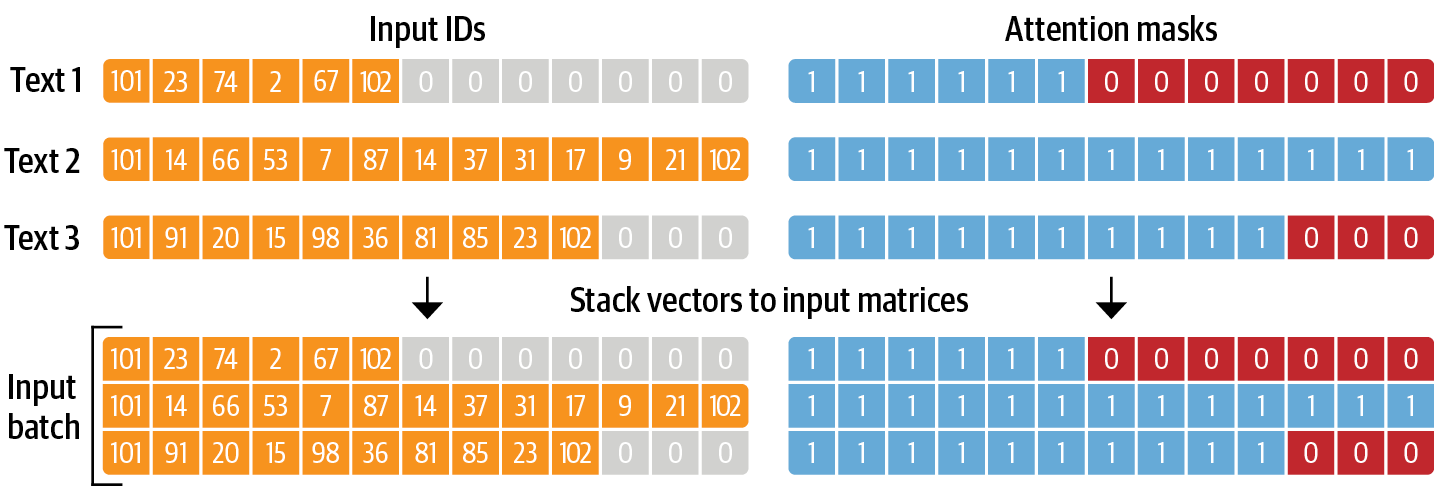

In [10]:
Image("images/chapter02_attention-mask.png", width=800)

Una vez que hemos definido una funci√≥n de procesamiento, podemos aplicarla a todos los splits en el corpus en una sola l√≠nea de c√≥digo:

In [ ]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Por defecto, el m√©todo `map()` opera individualmente en cada ejemplo en el corpus, por lo que establecer `batched=True` codificar√° los tweets en lotes. Debido a que hemos establecido `batch_size=None`, nuestra funci√≥n `tokenize()` se aplicar√° al conjunto de datos completo como un solo lote. Esto asegura que los tensores de entrada y las m√°scaras de atenci√≥n tengan la misma forma globalmente, y podemos ver que esta operaci√≥n ha a√±adido nuevas columnas `input_ids` y `attention_mask` al conjunto de datos:

In [ ]:
print(emotions_encoded["train"].column_names)

['attention_mask', 'input_ids', 'label', 'text']


> Nota: Los _data collators_ se pueden usar para rellenar din√°micamente los tensores en cada lote. El relleno (padding) global ser√° √∫til en la siguiente secci√≥n, donde extraemos una matriz de caracter√≠sticas de todo el corpus.

## Entrenando un Clasificador de Texto

Como se discuti√≥ anteriormente, los modelos como DistilBERT est√°n preentrenados para predecir palabras enmascaradas en una secuencia de texto. Sin embargo, no podemos usar estos modelos de lenguaje directamente para la clasificaci√≥n de texto; necesitamos modificarlos ligeramente. Para entender qu√© modificaciones son necesarias, echemos un vistazo a la arquitectura de un modelo basado en encoder como DistilBERT, que se muestra en la siguiente figura.

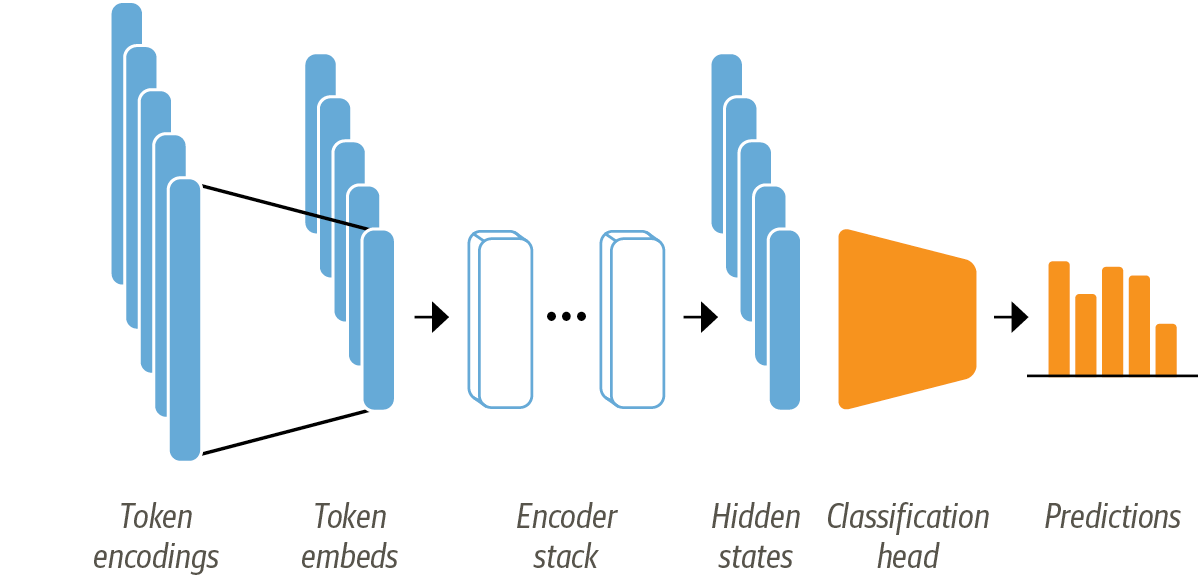

In [12]:
Image("images/chapter02_encoder-classifier.png", width=800)

Primero, el texto se tokeniza y se representa como vectores one-hot llamados _token encodings_. El tama√±o del vocabulario del tokenizer determina la dimensi√≥n de los token encodings, y generalmente consiste en 20k‚Äì200k tokens √∫nicos. Luego, estos token encodings se convierten en _token embeddings_, que son vectores que viven en un espacio de menor dimensi√≥n. Los token embeddings se pasan a trav√©s de las capas del bloque del encoder para producir un _estado oculto_ para cada token de entrada. Para el objetivo de preentrenamiento de modelado de lenguaje, cada estado oculto se alimenta a una capa que predice los tokens de entrada enmascarados. Para la tarea de clasificaci√≥n, reemplazamos la capa de modelado de lenguaje con una capa de clasificaci√≥n.

> nota: En la pr√°ctica, PyTorch omite el paso de crear vectores one-hot para los token encodings porque multiplicar una matriz con un vector one-hot es lo mismo que seleccionar una columna de la matriz. Esto se puede hacer directamente obteniendo la columna con el ID del token de la matriz. Esto sucede cuando por ejemplo se usa la clase `nn.Embedding`.

Tenemos dos opciones para entrenar un modelo as√≠ en nuestro conjunto de datos de Twitter:

- _Extracci√≥n de caracter√≠sticas_:: Usamos los estados ocultos como caracter√≠sticas y solo entrenamos un clasificador sobre ellos, sin modificar el modelo preentrenado.
- _Fine-tuning_:: Entrenamos todo el modelo de principio a fin, lo que tambi√©n actualiza los par√°metros del modelo preentrenado.

En las siguientes secciones exploramos ambas opciones para DistilBERT y examinamos sus ventajas y desventajas.

### Transformers como Extractores de Caracter√≠sticas

Usar un transformer como extractor de caracter√≠sticas es bastante simple. Como se muestra en la siguiente figura, congelamos los pesos del cuerpo durante el entrenamiento y usamos los estados ocultos como caracter√≠sticas para el clasificador. La ventaja de este enfoque es que podemos entrenar r√°pidamente un modelo peque√±o o superficial. Tal modelo podr√≠a ser una capa de clasificaci√≥n neuronal o un m√©todo que no dependa de gradientes, como un random forest. Este m√©todo es especialmente conveniente si no se dispone de GPUs, ya que los estados ocultos solo necesitan precomputarse una vez.

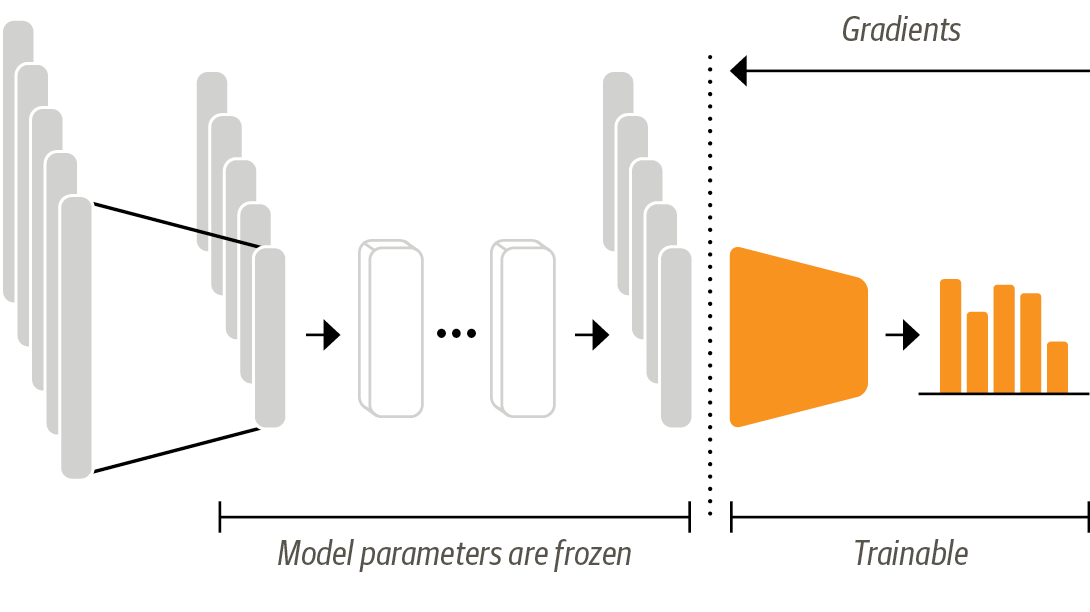

In [14]:
Image("images/chapter02_encoder-feature-based.png", width=800)

#### Usando modelos preentrenados

Usaremos otra clase _Auto_ conveniente de Hugging Face Transformers llamada `AutoModel`. Similar a la clase `AutoTokenizer`, `AutoModel` tiene un m√©todo `from_pretrained()` para cargar los pesos de un modelo preentrenado. Usemos este m√©todo para cargar el checkpoint de DistilBERT.

In [ ]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Aqu√≠ hemos usado PyTorch para verificar si hay una GPU disponible o no, y luego encadenamos el m√©todo `nn.Module.to()` de PyTorch al cargador del modelo. Esto asegura que el modelo se ejecutar√° en la GPU si tenemos una. Si no, el modelo se ejecutar√° en la CPU, lo que puede ser considerablemente m√°s lento.

La clase `AutoModel` convierte los token encodings en embeddings, y luego los alimenta a trav√©s de la pila del encoder para devolver los estados ocultos. Veamos c√≥mo podemos extraer estos estados de nuestro corpus.

#### Extrayendo los √∫ltimos estados ocultos

Para calentar, recuperemos los √∫ltimos estados ocultos para una sola cadena. Lo primero que necesitamos hacer es codificar la cadena y convertir los tokens en tensores de PyTorch. Esto se puede hacer proporcionando el argumento `return_tensors="pt"` al tokenizer de la siguiente manera:

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


Como podemos ver, el tensor resultante tiene la forma `[batch_size, n_tokens]`. Ahora que tenemos las codificaciones como un tensor, el paso final es colocarlas en el mismo dispositivo que el modelo y pasar las entradas de la siguiente manera:

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Aqu√≠ hemos usado `torch.no_grad()` para deshabilitar el c√°lculo autom√°tico del gradiente. Esto es √∫til para la inferencia ya que reduce la huella de memoria de los c√°lculos. Dependiendo de la configuraci√≥n del modelo, la salida puede contener varios objetos, como los estados ocultos, p√©rdidas o atenciones, organizados en una clase similar a un `namedtuple` en Python. En nuestro ejemplo, la salida del modelo es una instancia de `BaseModelOutput`, y simplemente podemos acceder a sus atributos por nombre. El modelo actual solo devuelve un atributo, que es el √∫ltimo estado oculto, as√≠ que examinemos su forma:


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Mirando el tensor del estado oculto, vemos que tiene la forma `[batch_size, n_tokens, hidden_dim]`. En otras palabras, se devuelve un vector de 768 dimensiones para cada uno de los 6 tokens de entrada. Para tareas de clasificaci√≥n, es una pr√°ctica com√∫n usar solo el estado oculto asociado con el token `[CLS]` como la caracter√≠stica de entrada. Dado que este token aparece al inicio de cada secuencia, podemos extraerlo simplemente indexando en `outputs.last_hidden_state` de la siguiente manera:

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Ahora que sabemos c√≥mo obtener el √∫ltimo estado oculto para una sola cadena, hagamos lo mismo para todo el conjunto de datos creando una nueva columna `hidden_state` que almacene todos estos vectores. Como hicimos con el tokenizer, usaremos el m√©todo `map()` de `DatasetDict` para extraer todos los estados ocultos de una vez. Lo primero que necesitamos hacer es envolver los pasos anteriores en una funci√≥n de procesamiento:

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

La √∫nica diferencia entre esta funci√≥n y nuestra l√≥gica anterior es el paso final donde colocamos el estado oculto final de nuevo en la CPU como un array de NumPy. El m√©todo `map()` requiere que la funci√≥n de procesamiento devuelva objetos de Python o NumPy cuando estamos usando entradas por lotes.

Dado que nuestro modelo espera tensores como entradas, lo siguiente que debemos hacer es convertir las columnas `input_ids` y `attention_mask` al formato `"torch"`, de la siguiente manera:

In [ ]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

Luego podemos proceder a extraer los estados ocultos en todos los splits de una vez:

In [ ]:
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Ten en cuenta que no establecimos `batch_size=None` en este caso, por lo que se usa el valor predeterminado `batch_size=1000`. Como era de esperar, aplicar la funci√≥n `extract_hidden_states` ha a√±adido una nueva columna `hidden_state` a nuestro conjunto de datos:

In [ ]:
emotions_hidden["train"].column_names

['attention_mask', 'hidden_state', 'input_ids', 'label', 'text']

Ahora que tenemos los estados ocultos asociados con cada tweet, el siguiente paso es entrenar un clasificador sobre ellos. Para hacer eso, necesitaremos una matriz de caracter√≠sticas - echemos un vistazo.

#### Creando una matriz de caracter√≠sticas

El conjunto de datos preprocesado ahora contiene toda la informaci√≥n que necesitamos para entrenar un clasificador sobre √©l. Usaremos los estados ocultos como caracter√≠sticas de entrada y las etiquetas como objetivos. Podemos crear f√°cilmente los arrays correspondientes en el formato bien conocido de Scikit-Learn de la siguiente manera:

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Antes de entrenar un modelo sobre los estados ocultos, es una buena pr√°ctica realizar una verificaci√≥n de cordura para asegurarnos de que proporcionan una representaci√≥n √∫til de las emociones que queremos clasificar. En la siguiente secci√≥n, veremos c√≥mo visualizar las caracter√≠sticas proporciona una forma r√°pida de lograr esto.

#### Visualizando el conjunto de entrenamiento

Dado que visualizar los estados ocultos en 768 dimensiones es complicado por decir lo menos, usaremos el poderoso algoritmo UMAPfootnote:[L. McInnes, J. Healy, y J. Melville, ["UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction"](https://arxiv.org/abs/1802.03426), (2018).] para proyectar los vectores a 2D. Dado que UMAP funciona mejor cuando las caracter√≠sticas est√°n escaladas para estar en el intervalo [0,1], primero aplicaremos un `MinMaxScaler` y luego usaremos la implementaci√≥n de UMAP de la biblioteca `umap-learn` para reducir los estados ocultos:

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

X         Y  label
0  4.358075  6.140816      0
1 -3.134567  5.329446      0
2  5.152230  2.732643      3
3 -2.519018  3.067250      2
4 -3.364520  3.356613      3

El resultado es un array con el mismo n√∫mero de muestras de entrenamiento, pero con solo 2 caracter√≠sticas en lugar de las 768 con las que comenzamos. Investigamos un poco m√°s los datos comprimidos y trazamos la densidad de puntos para cada categor√≠a por separado:

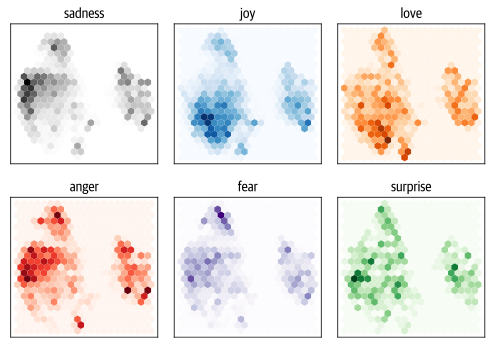

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


>nota: Estas son solo proyecciones a un espacio de menor dimensi√≥n. Solo porque algunas categor√≠as se superpongan no significa que no sean separables en el espacio original. Por el contrario, si son separables en el espacio proyectado, ser√°n separables en el espacio original.

De este gr√°fico podemos ver algunos patrones claros: los sentimientos negativos como `sadness`, `anger` y `fear` ocupan regiones similares con distribuciones ligeramente diferentes. Por otro lado, `joy` y `love` est√°n bien separados de las emociones negativas y tambi√©n comparten un espacio similar. Finalmente, `surprise` est√° disperso por todas partes. Aunque podr√≠amos haber esperado alguna separaci√≥n, esto no est√° garantizado ya que el modelo no fue entrenado para conocer la diferencia entre estas emociones. Solo las aprendi√≥ impl√≠citamente al adivinar las palabras enmascaradas en los textos.

Ahora que hemos obtenido una idea de las caracter√≠sticas de nuestro conjunto de datos, ¬°finalmente entrenemos un modelo sobre √©l!

#### Entrenando un clasificador simple

Hemos visto que los estados ocultos son algo diferentes entre las emociones, aunque para varias de ellas no hay un l√≠mite obvio. Usemos estos estados ocultos para entrenar un modelo de regresi√≥n log√≠stica con Scikit-Learn. Entrenar un modelo tan simple es r√°pido y no requiere una GPU:

In [ ]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.6085

Mirando la accuracy, podr√≠a parecer que nuestro modelo es solo un poco mejor que al azar, pero dado que estamos tratando con un conjunto de datos multiclase desequilibrado, en realidad es significativamente mejor. Podemos examinar si nuestro modelo es bueno compar√°ndolo con una l√≠nea base simple. En Scikit-Learn hay un `DummyClassifier` que se puede usar para construir un clasificador con heur√≠sticas simples como siempre elegir la clase mayoritaria o siempre elegir una clase al azar. En este caso, la heur√≠stica de mejor rendimiento es siempre elegir la clase m√°s frecuente, lo que produce una precisi√≥n de alrededor del 35%:

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

Entonces, nuestro clasificador simple con embeddings de DistilBERT es significativamente mejor que nuestra l√≠nea base. Podemos investigar m√°s a fondo el rendimiento del modelo observando la matriz de confusi√≥n del clasificador, que nos dice la relaci√≥n entre las etiquetas verdaderas y las predichas:

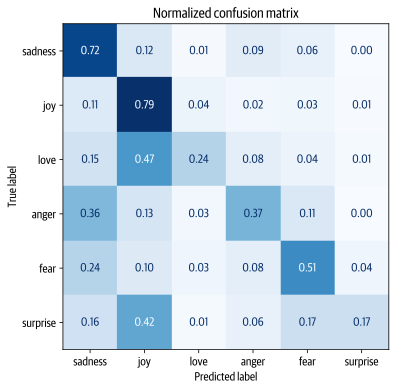

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Podemos ver que `anger` y `fear` se confunden m√°s a menudo con `sadness`, lo cual concuerda con la observaci√≥n que hicimos al visualizar los embeddings. Adem√°s, `love` y `surprise` se confunden frecuentemente con `joy`.

En la siguiente secci√≥n exploraremos el enfoque de fine-tuning, que conduce a un rendimiento de clasificaci√≥n superior. Sin embargo, es importante notar que hacer esto requiere m√°s recursos computacionales, como GPUs, que podr√≠an no estar disponibles en tu organizaci√≥n. En casos como estos, un enfoque basado en caracter√≠sticas puede ser un buen compromiso entre hacer machine learning tradicional y deep learning.

### Fine-Tuning Transformers

Ahora exploremos lo que se necesita para hacer fine-tuning a un transformer de principio a fin. Con el enfoque de fine-tuning no usamos los estados ocultos como caracter√≠sticas fijas, sino que los entrenamos como se muestra en la siguiente figura. Esto requiere que la cabeza de clasificaci√≥n sea diferenciable, por lo que este m√©todo usualmente usa una red neuronal para la clasificaci√≥n.

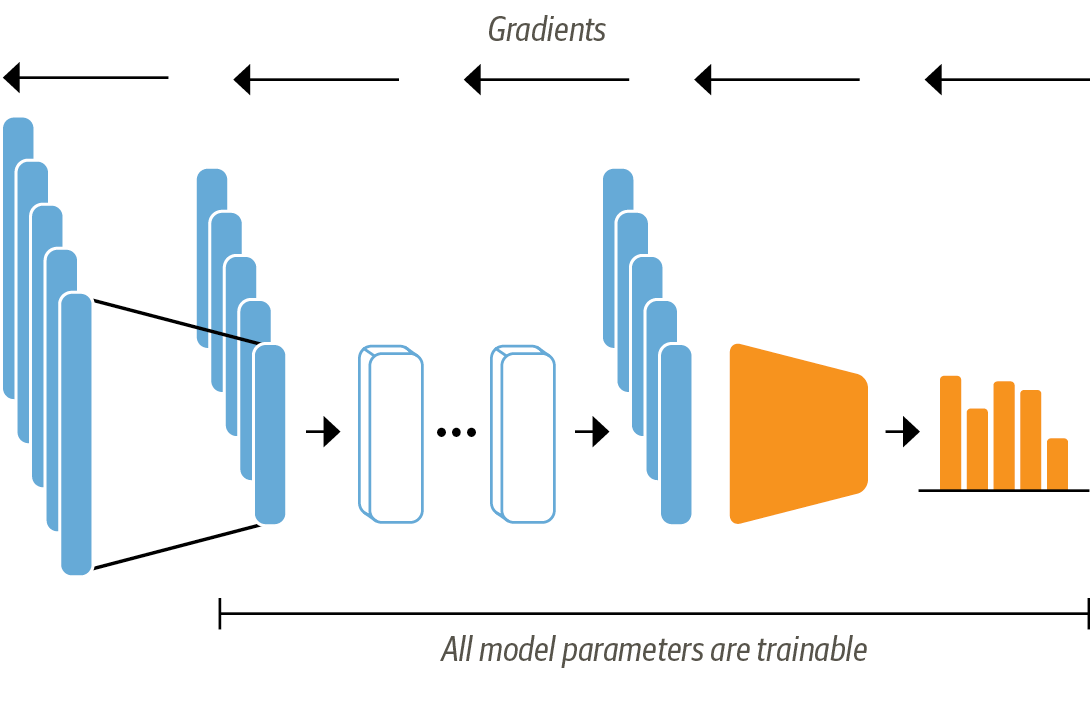

In [16]:
Image("images/chapter02_encoder-fine-tuning.png", width=800)

Entrenar los estados ocultos que sirven como entradas al modelo de clasificaci√≥n nos ayudar√° a evitar el problema de trabajar con datos que pueden no ser adecuados para la tarea de clasificaci√≥n. En su lugar, los estados ocultos iniciales se adaptan durante el entrenamiento para disminuir la p√©rdida del modelo y as√≠ aumentar su rendimiento.

Usaremos la API `Trainer` de HF Transformers para simplificar el bucle de entrenamiento. ¬°Veamos los ingredientes que necesitamos para configurarlo!

#### Cargando un modelo preentrenado

Lo primero que necesitamos es un modelo DistilBERT preentrenado como el que usamos en el enfoque basado en caracter√≠sticas. La √∫nica ligera modificaci√≥n es que usamos el modelo `AutoModelForSequenceClassification` en lugar de `AutoModel`. La diferencia es que el modelo `AutoModelForSequenceClassification` tiene una cabeza de clasificaci√≥n sobre las salidas del modelo preentrenado, que se puede entrenar f√°cilmente con el modelo base. Solo necesitamos especificar cu√°ntas etiquetas tiene que predecir el modelo (seis en nuestro caso), ya que esto dicta el n√∫mero de salidas que tiene la cabeza de clasificaci√≥n:

In [ ]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Ver√°s un warning de que algunas partes del modelo se inicializan aleatoriamente. Esto es normal ya que la cabeza de clasificaci√≥n a√∫n no ha sido entrenada. El siguiente paso es definir las m√©tricas que usaremos para evaluar el rendimiento de nuestro modelo durante el fine-tuning.

#### Definiendo las m√©tricas de rendimiento

Para monitorear las m√©tricas durante el entrenamiento, necesitamos definir una funci√≥n `compute_metrics()` para el `Trainer`. Esta funci√≥n recibe un objeto `EvalPrediction` (que es una tupla con atributos `predictions` y `label_ids`) y necesita devolver un diccionario que mapee el nombre de cada m√©trica a su valor. Para nuestra aplicaci√≥n, calcularemos el $F_1$-score y la precisi√≥n del modelo de la siguiente manera:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Con el conjunto de datos y las m√©tricas listas, solo nos quedan dos cosas finales por hacer antes de definir la clase `Trainer`:

1. Iniciar sesi√≥n en nuestra cuenta en el Hugging Face Hub. Esto nos permitir√° subir nuestro modelo fine-tuned a nuestra cuenta en el Hub y compartirlo con la comunidad.
2. Definir todos los hiperpar√°metros para la ejecuci√≥n del entrenamiento.

Abordaremos estos pasos en la siguiente secci√≥n.

#### Entrenando el modelo

Si est√°s ejecutando este c√≥digo en un notebook de Jupyter, puedes iniciar sesi√≥n en el Hub con la siguiente funci√≥n de ayuda:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

in[193]: Esto mostrar√° un widget en el que puedes ingresar tu nombre de usuario y contrase√±a, o un token de acceso con privilegios de escritura. Puedes encontrar detalles sobre c√≥mo crear tokens de acceso en la [documentaci√≥n del Hub](https://huggingface.co/docs/hub/security#user-access-tokens). Si est√°s trabajando en la terminal, puedes iniciar sesi√≥n ejecutando el siguiente comando:

```bash
$ huggingface-cli login
```

Para definir los par√°metros de entrenamiento, usamos la clase `TrainingArguments`. Esta clase almacena mucha informaci√≥n y te da un control detallado sobre el entrenamiento y la evaluaci√≥n. El argumento m√°s importante a especificar es `output_dir`, que es donde se almacenan todos los artefactos del entrenamiento. Aqu√≠ hay un ejemplo de `TrainingArguments` en todo su esplendor:

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

Aqu√≠ tambi√©n establecemos el tama√±o del lote, la tasa de aprendizaje y el n√∫mero de √©pocas, y especificamos cargar el mejor modelo al final de la ejecuci√≥n del entrenamiento. Con este ingrediente final, podemos instanciar y hacer fine-tuning a nuestro modelo con el `Trainer`:

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Mirando los logs, podemos ver que nuestro modelo tiene un $F_1$-score en el conjunto de validaci√≥n de alrededor del 92% - ¬°esto es una mejora significativa sobre el enfoque basado en caracter√≠sticas!

Podemos echar un vistazo m√°s detallado a las m√©tricas de entrenamiento calculando la matriz de confusi√≥n. Para visualizar la matriz de confusi√≥n, primero necesitamos obtener las predicciones en el conjunto de validaci√≥n. El m√©todo `predict()` de la clase `Trainer` devuelve varios objetos √∫tiles que podemos usar para la evaluaci√≥n:

In [ ]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

La salida del m√©todo `predict()` es un objeto `PredictionOutput` que contiene arrays de `predictions` y `label_ids`, junto con las m√©tricas que pasamos al entrenador. Por ejemplo, las m√©tricas en el conjunto de validaci√≥n se pueden acceder de la siguiente manera:

In [ ]:
preds_output.metrics

{'test_loss': 0.22047173976898193,
 'test_accuracy': 0.9225,
 'test_f1': 0.9225500751072866,
 'test_runtime': 1.6357,
 'test_samples_per_second': 1222.725,
 'test_steps_per_second': 19.564}

Tambi√©n contiene las predicciones en bruto para cada clase. Podemos decodificar las predicciones de manera codiciosa usando `np.argmax()`. Esto produce las etiquetas predichas y tiene el mismo formato que las etiquetas devueltas por los modelos de Scikit-Learn en el enfoque basado en caracter√≠sticas:

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

Con las predicciones, podemos trazar la matriz de confusi√≥n nuevamente:

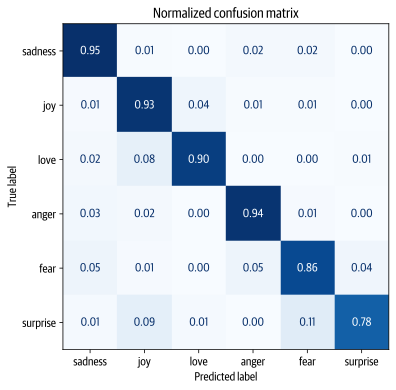

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

Esto est√° mucho m√°s cerca de la matriz de confusi√≥n diagonal ideal. La categor√≠a `love` todav√≠a se confunde a menudo con `joy`, lo cual parece natural. `surprise` tambi√©n se confunde frecuentemente con `joy`, o se confunde con `fear`. En general, el rendimiento del modelo parece bastante bueno, pero antes de darlo por terminado, profundicemos un poco m√°s en los tipos de errores que es probable que cometa nuestro modelo.

#### Error analysis

Antes de continuar, deber√≠amos investigar un poco m√°s las predicciones de nuestro modelo. Una t√©cnica simple pero poderosa es ordenar las muestras de validaci√≥n por la p√©rdida del modelo. Cuando pasamos la etiqueta durante el forward pass, la p√©rdida se calcula y devuelve autom√°ticamente. Aqu√≠ hay una funci√≥n que devuelve la p√©rdida junto con la etiqueta predicha:

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

Usando el m√©todo `map()` una vez m√°s, podemos aplicar esta funci√≥n para obtener las p√©rdidas de todas las muestras:

In [ ]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

Finalmente, creamos un `DataFrame` con los textos, p√©rdidas y etiquetas predichas/verdaderas:

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Ahora podemos ordenar f√°cilmente `emotions_encoded` por las p√©rdidas en orden ascendente o descendente. El objetivo de este ejercicio es detectar uno de los siguientes:

- _Etiquetas incorrectas_: Todo proceso que a√±ade etiquetas a los datos puede ser defectuoso. Los anotadores pueden cometer errores o no estar de acuerdo, mientras que las etiquetas que se infieren de otras caracter√≠sticas pueden estar equivocadas. Si fuera f√°cil anotar datos autom√°ticamente, entonces no necesitar√≠amos un modelo para hacerlo. Por lo tanto, es normal que haya algunos ejemplos mal etiquetados. Con este enfoque, podemos encontrarlos y corregirlos r√°pidamente.

- _Particularidades del conjunto de datos_: Los conjuntos de datos en el mundo real siempre son un poco desordenados. Cuando se trabaja con texto, los caracteres especiales o cadenas en las entradas pueden tener un gran impacto en las predicciones del modelo. Inspeccionar las predicciones m√°s d√©biles del modelo puede ayudar a identificar tales caracter√≠sticas, y limpiar los datos o inyectar ejemplos similares puede hacer que el modelo sea m√°s robusto.

Primero echemos un vistazo a las muestras de datos con las p√©rdidas m√°s altas:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

text     label  \
1801  i feel that he was being overshadowed by the s...      love   
1963  i called myself pro life and voted for perry w...       joy   
1870  i guess i feel betrayed because i admired him ...       joy   
882   i feel badly about reneging on my commitment t...      love   
1950  i as representative of everything thats wrong ...  surprise   
1509  i guess this is a memoir so it feels like that...       joy   
1274  i am going to several holiday parties and i ca...       joy   
318   i felt ashamed of these feelings and was scare...      fear   
1500  i guess we would naturally feel a sense of lon...     anger   
1111  im lazy my characters fall into categories of ...       joy   

     predicted_label      loss  
1801         sadness  5.704531  
1963         sadness  5.484461  
1870         sadness  5.434768  
882          sadness  5.257482  
1950         sadness  4.827708  
1509            fear  4.713047  
1274         sadness  4.704955  
318          sadness  4.656096  
1500         sadness  4.593202  
1111            fear  4.311287

Podemos ver claramente que el modelo predijo algunas de las etiquetas incorrectamente. Por otro lado, parece que hay bastantes ejemplos sin una clase clara, que podr√≠an estar mal etiquetados o requerir una nueva clase por completo. En particular, `joy` parece estar mal etiquetado varias veces. Con esta informaci√≥n podemos refinar el conjunto de datos, lo que a menudo puede llevar a una ganancia de rendimiento tan grande (o m√°s) como tener m√°s datos o modelos m√°s grandes.

Al observar las muestras con las p√©rdidas m√°s bajas, observamos que el modelo parece estar m√°s seguro al predecir la clase `sadness`. Los modelos de deep learning son excepcionalmente buenos para encontrar y explotar atajos para llegar a una predicci√≥n. Por esta raz√≥n, tambi√©n vale la pena invertir tiempo en observar los ejemplos sobre los que el modelo est√° m√°s seguro, para que podamos estar seguros de que el modelo no explota indebidamente ciertas caracter√≠sticas del texto. As√≠ que, tambi√©n echemos un vistazo a las predicciones con la menor p√©rdida:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

text    label  \
21    i feel try to tell me im ungrateful tell me im...  sadness   
244   im kinda relieve but at the same time i feel d...  sadness   
133   i and feel quite ungrateful for it but i m loo...  sadness   
392   i remember feeling disheartened one day when w...  sadness   
1310                  i feel like an ungrateful asshole  sadness   
189   i leave the meeting feeling more than a little...  sadness   
1120                 i am feeling a little disheartened  sadness   
783   i feel like i deserve to be broke with how fri...  sadness   
1368  i started this blog with pure intentions i mus...  sadness   
1466  i feel so ungrateful to be wishing this pregna...  sadness   

     predicted_label      loss  
21           sadness  0.017331  
244          sadness  0.017392  
133          sadness  0.017400  
392          sadness  0.017461  
1310         sadness  0.017485  
189          sadness  0.017670  
1120         sadness  0.017685  
783          sadness  0.017888  
1368         sadness  0.017899  
1466         sadness  0.017913

Ahora sabemos que `joy` a veces est√° mal etiquetado y que el modelo est√° m√°s seguro al predecir la etiqueta `sadness`. Con esta informaci√≥n podemos hacer mejoras espec√≠ficas a nuestro conjunto de datos, y tambi√©n estar atentos a la clase sobre la que el modelo parece estar muy seguro.

El √∫ltimo paso antes de servir el modelo entrenado es guardarlo para su uso posterior. HF Transformers nos permite hacer esto en unos pocos pasos, que te mostraremos en la siguiente secci√≥n.

#### Guardando y compartiendo el modelo

La comunidad de NLP se beneficia enormemente de compartir modelos preentrenados y fine-tuned, y todos pueden compartir sus modelos con otros a trav√©s del Hugging Face Hub. Cualquier modelo generado por la comunidad se puede descargar del Hub tal como descargamos el modelo DistilBERT. Con la API `Trainer`, guardar y compartir un modelo es simple:

In [ ]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/lewtun/distilbert-base-uncased-finetuned-emotion/commit/352c4147e4754f73a0b41f7b175f4a907270c9c9'

Tambi√©n podemos usar el modelo fine-tuned para hacer predicciones en nuevos tweets. Dado que hemos subido nuestro modelo al Hub, ahora podemos usarlo con la funci√≥n `pipeline()`. Primero, carguemos el pipeline:

In [ ]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Entonces, probemos el pipeline con un tuit de ejemplo:

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

Finalmente, podemos trazar la probabilidad para cada clase en un gr√°fico de barras. Claramente, el modelo estima que la clase m√°s probable es `joy`, lo cual parece razonable dado el tweet:

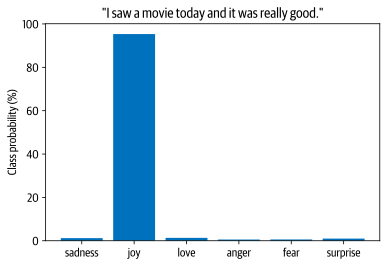

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusi√≥n

¬°Felicidades, ahora sabes c√≥mo entrenar un modelo transformer para clasificar las emociones en tweets! Hemos visto dos enfoques complementarios basados en caracter√≠sticas y fine-tuning, y hemos investigado sus fortalezas y debilidades.

Sin embargo, este es solo el primer paso para construir una aplicaci√≥n del mundo real con modelos transformer, y tenemos mucho m√°s terreno por cubrir. Aqu√≠ hay una lista de desaf√≠os que probablemente experimentar√°s en tu viaje de NLP:

Mi jefe quiere mi modelo en producci√≥n ayer!:
En la mayor√≠a de las aplicaciones, tu modelo no solo se sienta en alg√∫n lugar acumulando polvo - ¬°quieres asegurarte de que est√° sirviendo predicciones! Cuando un modelo se sube al Hub, se crea autom√°ticamente un endpoint de inferencia que se puede llamar con solicitudes HTTP. Recomendamos revisar la [documentaci√≥n](https://api-inference.huggingface.co/docs/python/html/index.html) de la API de Inferencia si quieres aprender m√°s.

¬°Mis usuarios quieren predicciones m√°s r√°pidas!:
Ya hemos visto un enfoque para este problema: usar DistilBERT. En <<chapter_compression>> profundizaremos en la destilaci√≥n de conocimiento (el proceso por el cual se cre√≥ DistilBERT), junto con otros trucos para acelerar tus modelos transformer.

¬øPuede tu modelo tambi√©n hacer X?:
Como hemos insinuado en este cap√≠tulo, los transformers son extremadamente vers√°tiles. En el resto del libro exploraremos una gama de tareas, como question answering y named entity recognition, todo usando la misma arquitectura b√°sica.

¬°Ninguno de mis textos est√° en ingl√©s!:
Resulta que los transformers tambi√©n vienen en una variedad multiling√ºe

¬°No tengo ninguna etiqueta!::
Si hay muy pocos datos etiquetados disponibles, el fine-tuning puede no ser una opci√≥n. 